#Final Project - Music Hit Prediction

- What did we do

Predict whether a song will be a hit song based on audio features

- How we did

Build a classification model to predict hit potential (Hit=1, Not Hit=0) using Spotify audio features.

# 0: Import libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             f1_score, roc_curve, auc, ConfusionMatrixDisplay,
                             precision_score, recall_score)

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

RANDOM_STATE = 42

# Part 1: Operation Extract

## 1.1 Prepare the data

### (a) Use a public CSV

We picked [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset) as the main dataset, because:
- It includes various audio features like danceability, speechiness, instrumentalness.
- It involves 114,000 records, which helps improving the accuracy of the model.
- It has been tested by hundreds of users.

### (b) Build dataset from APIs (Bonus)

Install required packages before requesting from local machine.

In [ ]:
# pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

Then run the script to fetch tracks info from Spotify.

In [ ]:
import requests
import base64
import csv
import time
from datetime import datetime
from google.colab import userdata

CLIENT_ID = userdata.get('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = userdata.get('SPOTIFY_CLIENT_SECRET')

BATCH_SIZE = 100

def get_access_token():
    auth_url = "https://accounts.spotify.com/api/token"

    credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
    encoded_credentials = base64.b64encode(credentials.encode()).decode()

    headers = {
        "Authorization": f"Basic {encoded_credentials}",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}

    response = requests.post(auth_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        print(f"Error getting token: {response.status_code}")
        print(response.text)
        return None

def search_tracks(access_token, query, limit=50, offset=0):
    search_url = "https://api.spotify.com/v1/search"

    headers = {"Authorization": f"Bearer {access_token}"}
    params = {
        "q": query,
        "type": "track",
        "limit": limit,
        "offset": offset
    }

    response = requests.get(search_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 429:
        retry_after = int(response.headers.get('Retry-After', 5))
        print(f"Rate limited. Waiting {retry_after} seconds...")
        time.sleep(retry_after)
        return search_tracks(access_token, query, limit, offset)
    else:
        print(f"Search error: {response.status_code}")
        print(response.text)
        return None

def get_audio_features(access_token, track_ids):
    if not track_ids:
        return []

    features_url = "https://api.spotify.com/v1/audio-features"

    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"ids": ",".join(track_ids)}

    response = requests.get(features_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json().get("audio_features", [])
    elif response.status_code == 429:
        retry_after = int(response.headers.get('Retry-After', 5))
        print(f"Rate limited. Waiting {retry_after} seconds...")
        time.sleep(retry_after)
        return get_audio_features(access_token, track_ids)
    else:
        print(f"Audio features error: {response.status_code}")
        print(response.text)
        return []

def get_artist_genres(access_token, artist_ids):
    genres_map = {}

    if not artist_ids:
        return genres_map

    for i in range(0, len(artist_ids), 50):
        batch = artist_ids[i:i+50]
        artists_url = "https://api.spotify.com/v1/artists"

        headers = {"Authorization": f"Bearer {access_token}"}
        params = {"ids": ",".join(batch)}

        response = requests.get(artists_url, headers=headers, params=params)
        if response.status_code == 200:
            artists_data = response.json().get("artists", [])
            for artist in artists_data:
                if artist:
                    genres = artist.get("genres", [])
                    genres_map[artist["id"]] = genres[0] if genres else "various"

        time.sleep(0.3)

    return genres_map


def main():
    access_token = get_access_token()

    if not access_token:
        print("Error: Failed to get access token.")
        return

    search_queries = [
        "year:2024",
        "year:2025",
        "year:2024 pop",
        "year:2024 rock",
        "year:2024 indie",
        "year:2025 pop",
        "year:2024 electronic",
        "year:2024 hip-hop",
        "year:2024 r&b",
        "year:2024 acoustic",
        "year:2024 latin",
        "year:2024 dance",
        "new release 2024",
        "top hits 2024",
        "viral 2024"
    ]

    all_tracks = {}
    artist_ids_set = set()

    for query in search_queries:
        if len(all_tracks) >= BATCH_SIZE:
            break

        results = search_tracks(access_token, query, limit=50, offset=0)

        if results and "tracks" in results and "items" in results["tracks"]:
            tracks_found = 0
            for track in results["tracks"]["items"]:
                if len(all_tracks) >= BATCH_SIZE:
                    break

                track_id = track["id"]
                if track_id not in all_tracks:
                    artists = ";".join([artist["name"] for artist in track["artists"]])
                    first_artist_id = track["artists"][0]["id"] if track["artists"] else None

                    if first_artist_id:
                        artist_ids_set.add(first_artist_id)

                    all_tracks[track_id] = {
                        "track_id": track_id,
                        "artists": artists,
                        "album_name": track["album"]["name"],
                        "track_name": track["name"],
                        "popularity": track["popularity"],
                        "duration_ms": track["duration_ms"],
                        "explicit": track["explicit"],
                        "first_artist_id": first_artist_id
                    }
                    tracks_found += 1

        time.sleep(0.5)

    track_ids = list(all_tracks.keys())
    all_features = []

    for i in range(0, len(track_ids), BATCH_SIZE):
        batch_ids = track_ids[i:i+BATCH_SIZE]
        features = get_audio_features(access_token, batch_ids)
        if features:
            all_features.extend(features)
        time.sleep(0.5)

    artist_ids_list = list(artist_ids_set)
    artist_genres = get_artist_genres(access_token, artist_ids_list)

    features_lookup = {}
    for feat in all_features:
        if feat:
            features_lookup[feat["id"]] = feat

    final_tracks = []
    for track_id in track_ids:
        track_data = all_tracks[track_id]
        audio_feat = features_lookup.get(track_id, {})

        first_artist_id = track_data.get("first_artist_id")
        genre = artist_genres.get(first_artist_id, "various") if first_artist_id else "various"

        final_track = {
            "track_id": track_data["track_id"],
            "artists": track_data["artists"],
            "album_name": track_data["album_name"],
            "track_name": track_data["track_name"],
            "popularity": track_data["popularity"],
            "duration_ms": track_data["duration_ms"],
            "explicit": track_data["explicit"],
            "danceability": audio_feat.get("danceability", 0),
            "energy": audio_feat.get("energy", 0),
            "key": audio_feat.get("key", 0),
            "loudness": audio_feat.get("loudness", 0),
            "mode": audio_feat.get("mode", 0),
            "speechiness": audio_feat.get("speechiness", 0),
            "acousticness": audio_feat.get("acousticness", 0),
            "instrumentalness": audio_feat.get("instrumentalness", 0),
            "liveness": audio_feat.get("liveness", 0),
            "valence": audio_feat.get("valence", 0),
            "tempo": audio_feat.get("tempo", 0),
            "time_signature": audio_feat.get("time_signature", 4),
            "track_genre": genre
        }
        final_tracks.append(final_track)

    # save to csv file
    output_file = "spotify_tracks.csv"
    columns = [
        "", "track_id", "artists", "album_name", "track_name", "popularity",
        "duration_ms", "explicit", "danceability", "energy", "key", "loudness",
        "mode", "speechiness", "acousticness", "instrumentalness", "liveness",
        "valence", "tempo", "time_signature", "track_genre"
    ]

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(columns)

        for idx, track in enumerate(final_tracks):
            row = [
                idx,
                track["track_id"],
                track["artists"],
                track["album_name"],
                track["track_name"],
                track["popularity"],
                track["duration_ms"],
                str(track["explicit"]).upper(),
                track["danceability"],
                track["energy"],
                track["key"],
                track["loudness"],
                track["mode"],
                track["speechiness"],
                track["acousticness"],
                track["instrumentalness"],
                track["liveness"],
                track["valence"],
                track["tempo"],
                track["time_signature"],
                track["track_genre"]
            ]
            writer.writerow(row)

if __name__ == "__main__":
    main()


Run the script to fetch info from last.fm.

In [ ]:
import requests
import hashlib
from google.colab import userdata

API_KEY = userdata.get('LASTFM_API_KEY')
API_SECRET = userdata.get('LASTFM_API_SECRET')
BASE_URL = "https://ws.audioscrobbler.com/2.0/"

def make_request(params: dict) -> dict:
    try:
        response = requests.get(BASE_URL, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        return {"error": True, "message": f"Request failed: {str(e)}"}
    except ValueError as e:
        return {"error": True, "message": f"Invalid JSON response: {str(e)}"}

def get_chart_top_tracks(limit: int = 20) -> dict:
    params = {
        "method": "chart.getTopTracks",
        "api_key": API_KEY,
        "limit": limit,
        "format": "json"
    }
    return make_request(params)

def fetch_and_save_top_tracks(limit: int = 100, output_file: str = "lastfm_tracks.csv") -> None:
    import csv

    data = get_chart_top_tracks(limit=limit)

    if "error" in data:
        print(f"Error: {data.get('message', 'Unknown error')}")
        return

    if "tracks" not in data:
        print("No tracks found in response.")
        return

    tracks = data["tracks"].get("track", [])

    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Rank", "Track Name", "Artist", "Playcount", "Listeners", "URL"
        ])

        for i, track in enumerate(tracks, 1):
            artist_name = track.get("artist", {})
            if isinstance(artist_name, dict):
                artist_name = artist_name.get("name", "N/A")

            writer.writerow([
                i,
                track.get("name", "N/A"),
                artist_name,
                track.get("playcount", "N/A"),
                track.get("listeners", "N/A"),
                track.get("url", "N/A")
            ])

    print(f"Saved {len(tracks)} tracks to {output_file}")


if __name__ == "__main__":
    fetch_and_save_top_tracks(limit=100, output_file="lastfm_tracks.csv")

Get 'Spotify Tracks Dataset.csv' after combining public and our own dataset locally.

## 1.2 Load dataset

In [2]:
DATA_FILE = 'Spotify Tracks Dataset.csv'

df = pd.read_csv(DATA_FILE)

print("Dataset loaded")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

df.head()

Dataset loaded
Shape: 114,000 rows × 21 columns


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 1.3 Data cleaning

Remove useless rows and columns.

In [3]:
print(f"Original rows: {len(df):,}\n")

# Remove unnamed index column
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("Dropped 'Unnamed: 0' column")

# Remove duplicate rows
duplicates = df.duplicated(subset='track_id').sum()
if duplicates > 0:
    df = df.drop_duplicates(subset='track_id', keep='first')
    print(f"Removed {duplicates:,} duplicate tracks")

# Remove rows with missing values in important columns
important_columns = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                     'key', 'mode', 'time_signature']
existing_important = [col for col in important_columns if col in df.columns]
rows_with_missing = df[existing_important].isnull().any(axis=1).sum()

if rows_with_missing > 0:
    df = df.dropna(subset=existing_important)
    print(f"Removed {rows_with_missing:,} rows with missing values")

print(f"\nRows after cleaning: {len(df):,}")

Original rows: 114,000

Dropped 'Unnamed: 0' column
Removed 24,259 duplicate tracks

Rows after cleaning: 89,741


## 1.4 Engineer at 2 features (BONUS)

Create 2 new engineered features from existing data.

In [4]:
engineered_features = []

# duration in min
df['duration_min'] = df['duration_ms'] / 60000
engineered_features.append('duration_min')

# normalized loudness
df['loudness_normalized'] = (df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
engineered_features.append('loudness_normalized')

## 1.5 Create target variable

According to paper [DECODING SPOTIFY HITS: STATISTICAL AND PREDICTIVE ANALYSIS OF TRACK FEATURES DRIVING SONG POPULARITY](https://www.abacademies.org/articles/decoding-spotify-hits-statistical-and-predictive-analysis-of-track-features-driving-song-popularity.pdf), songs were classified into "popular" with popularity above 65.

So we picked *65* as the threshold of a hit song.

In [5]:
HIT_THRESHOLD = 65

df['is_hit'] = (df['popularity'] >= HIT_THRESHOLD).astype(int)

hit_count = df['is_hit'].sum()
not_hit_count = len(df) - hit_count

print(f"Hit (1):     {hit_count:>8,} ({hit_count/len(df)*100:.1f}%)")
print(f"Not hit (0): {not_hit_count:>8,} ({not_hit_count/len(df)*100:.1f}%)")

Hit (1):        5,763 (6.4%)
Not hit (0):   83,978 (93.6%)


Check data after cleaning, creating engineer features and target variable.

In [6]:
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

df.head()

Shape: 89,741 rows × 23 columns


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_min,loudness_normalized,is_hit
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3.844433,0.791392,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2.493500,0.597377,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,3.513767,0.736123,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3.365550,0.573701,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,3.314217,0.737103,1


Save the processed dataset.

In [7]:
os.makedirs('Data', exist_ok=True)
df.to_csv('Data/processed_music_dataset.csv', index=False)

## 1.6 Visualizations

- popularity histogram

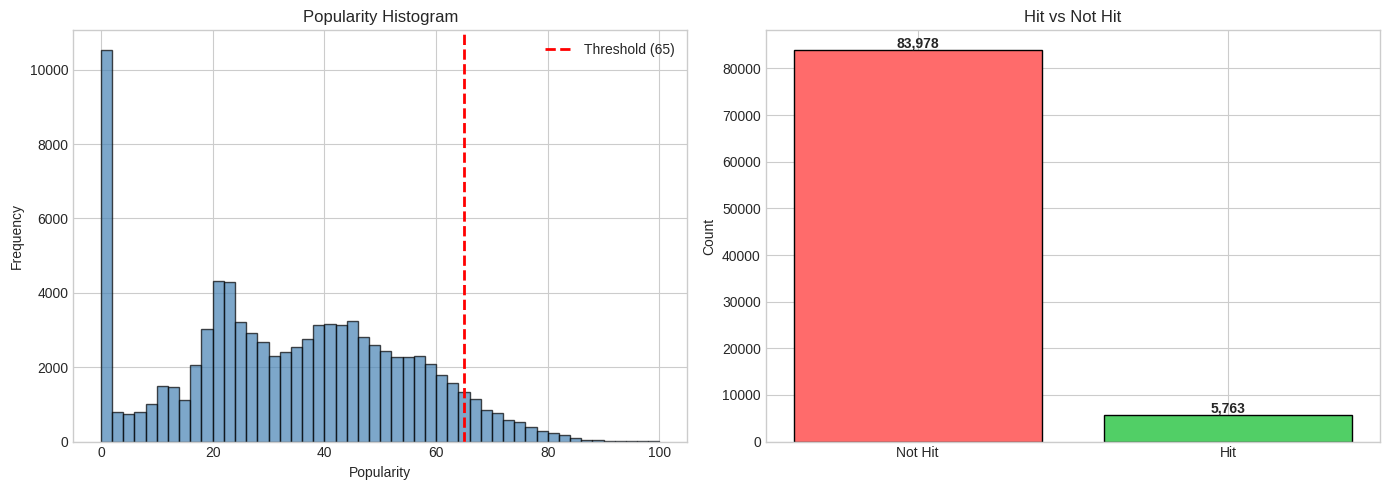

In [8]:
os.makedirs('visualizations', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['popularity'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=HIT_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({HIT_THRESHOLD})')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Popularity Histogram')
axes[0].legend()

hit_counts = df['is_hit'].value_counts().sort_index()
axes[1].bar(['Not Hit', 'Hit'], hit_counts.values, color=['#ff6b6b', '#51cf66'], edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('Hit vs Not Hit')
for i, v in enumerate(hit_counts.values):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/popularity_histogram.png', dpi=150)
plt.show()

- features boxplot

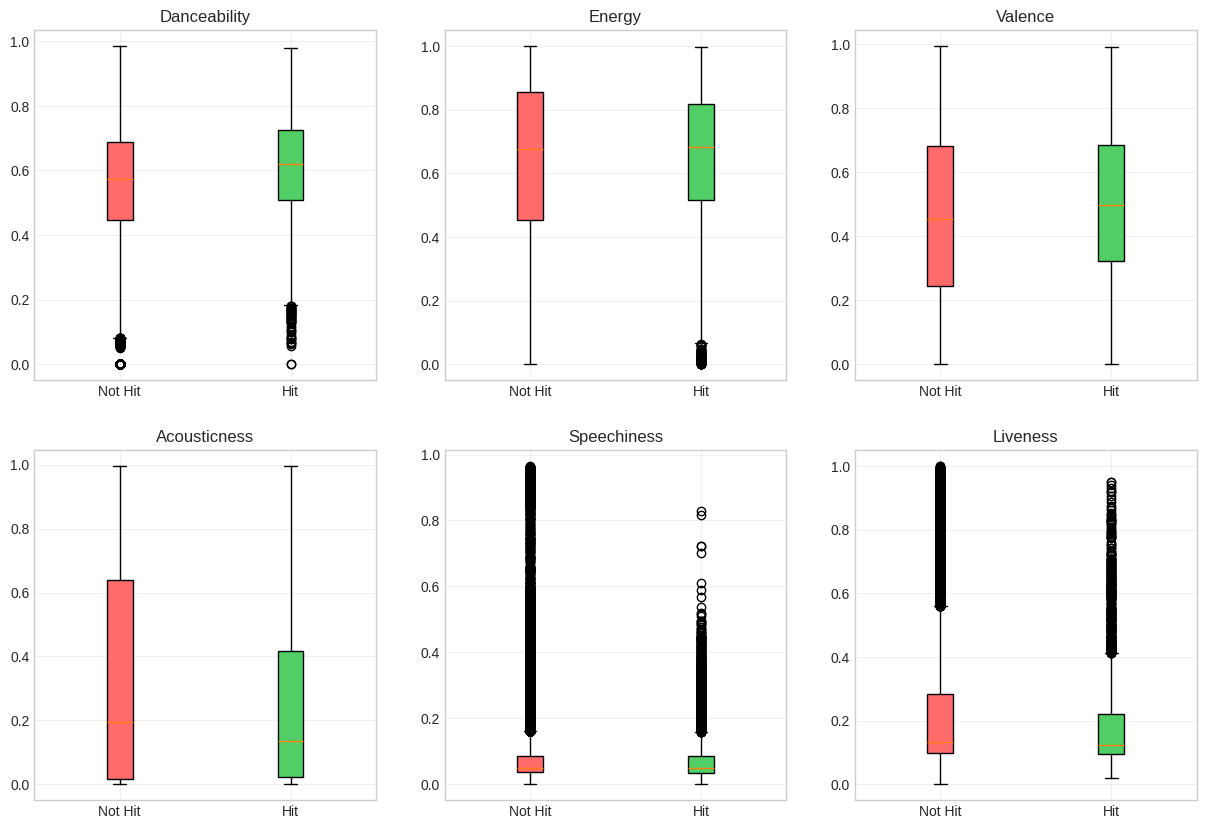

In [9]:
audio_plot = ['danceability', 'energy', 'valence', 'acousticness', 'speechiness', 'liveness']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(audio_plot):
    data = [df[df['is_hit']==0][col], df[df['is_hit']==1][col]]
    bp = axes[idx].boxplot(data, labels=['Not Hit', 'Hit'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#ff6b6b')
    bp['boxes'][1].set_facecolor('#51cf66')
    axes[idx].set_title(f'{col.capitalize()}')
    axes[idx].grid(True, alpha=0.3)

plt.savefig('visualizations/features_boxplot.png', dpi=150)
plt.show()

- correlation heatmap

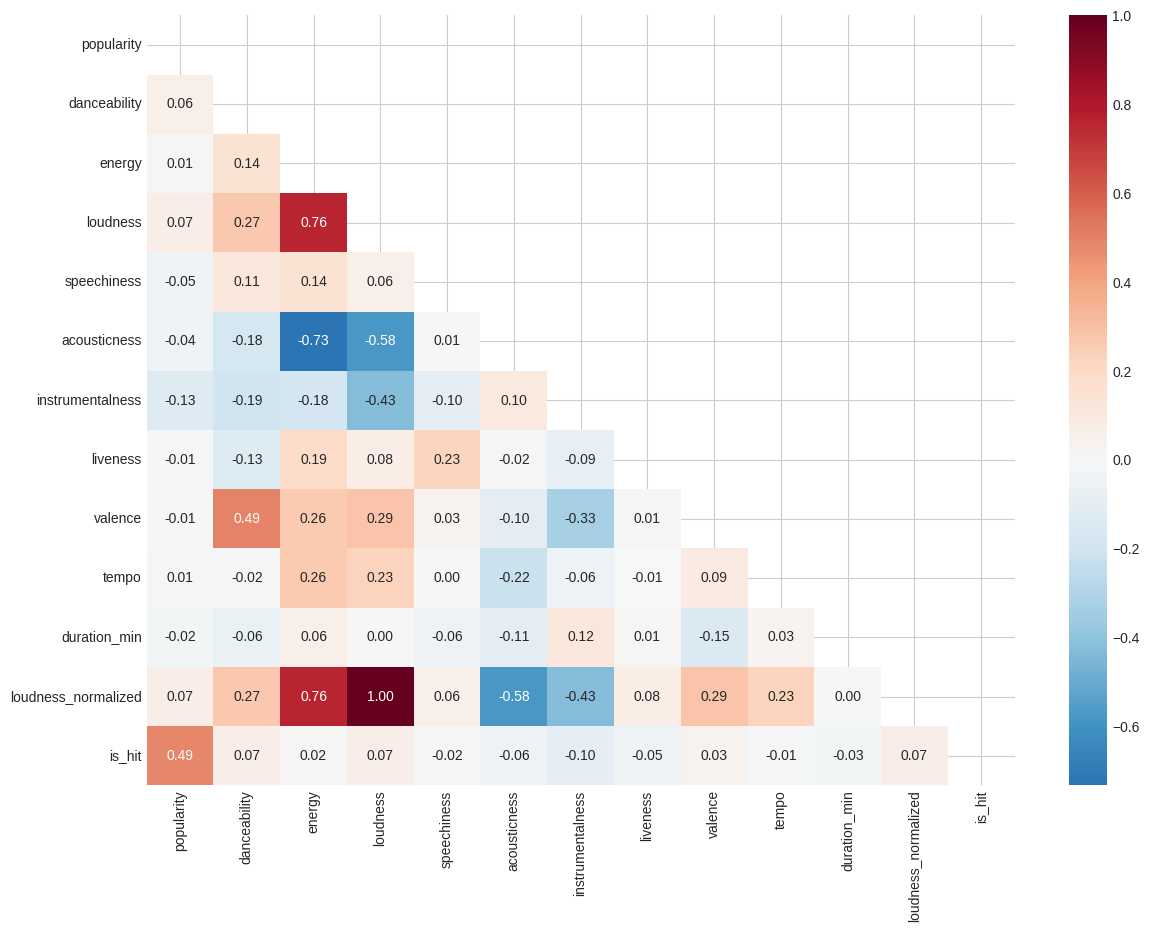

In [10]:
plt.figure(figsize=(14, 10))

corr_cols = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
             'duration_min', 'loudness_normalized', 'is_hit']
corr_cols = [c for c in corr_cols if c in df.columns]

corr = df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt='.2f')

plt.savefig('visualizations/correlation_heatmap.png', dpi=150)
plt.show()

# Part 2: Operation Learn

## 2.1 Train models

Prepare data to train & test.

In [11]:
feature_columns = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'key', 'mode', 'time_signature', 'duration_min', 'loudness_normalized'
]

X = df[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
y = df['is_hit']

print(f"X: {X.shape}")
print(f"y: 1(is hit)={sum(y==1):,}, 0(not hit)={sum(y==0):,}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTracks to train: {len(X_train):,}")
print(f"Tracks to test: {len(X_test):,}")

X: (89741, 14)
y: 1(is hit)=5,763, 0(not hit)=83,978

Tracks to train: 71,792
Tracks to test: 17,949


Train three models:
- Decision Tree
- Random Forest
- XGBoost (bonus)

In [12]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, max_depth=15),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss',
                             use_label_encoder=False, max_depth=6, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"{name} training begins")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{name} training ends")

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        'model': model, 'accuracy': acc, 'f1_score': f1, 'roc_auc': roc_auc,
        'precision': precision_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred, 'probabilities': y_proba, 'fpr': fpr, 'tpr': tpr
    }

Decision Tree training begins
Decision Tree training ends
Random Forest training begins
Random Forest training ends
XGBoost training begins
XGBoost training ends


## 2.3 Evaluation

In [17]:
comparison = pd.DataFrame([{
    'Model': n,
    'Accuracy': r['accuracy'],
    'F1': r['f1_score'],
    'AUC': r['roc_auc']
} for n, r in results.items()]).sort_values('F1', ascending=False)

print(comparison.to_string(index=False))
best_model_name = comparison.iloc[0]['Model']
print(f"\nThe best model is {best_model_name}")

        Model  Accuracy       F1      AUC
      XGBoost  0.935261 0.010221 0.717266
Decision Tree  0.932754 0.004946 0.687211
Random Forest  0.935707 0.000000 0.719470

The best model is XGBoost


Show the confusion matrix of each model.

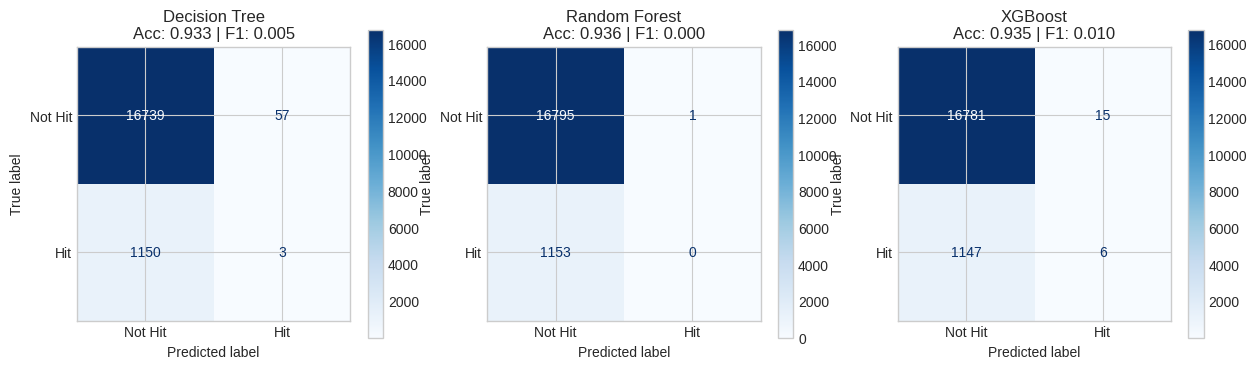

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, r) in enumerate(results.items()):
    ConfusionMatrixDisplay(r['confusion_matrix'], display_labels=['Not Hit', 'Hit']).plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f"{name}\nAcc: {r['accuracy']:.3f} | F1: {r['f1_score']:.3f}")

plt.savefig('visualizations/confusion_matrix.png', dpi=150)
plt.show()

Show the ROC curve of each model.

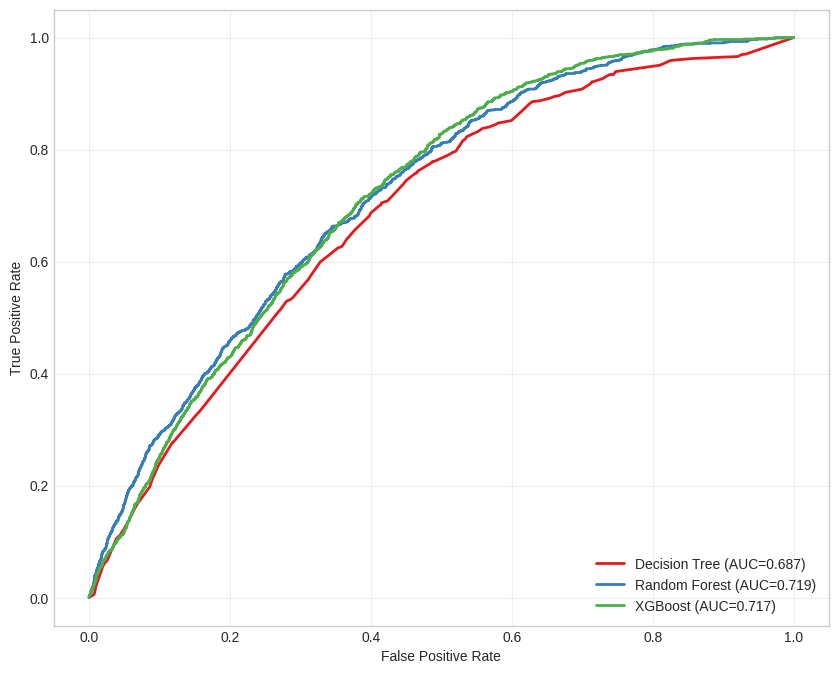

In [25]:
plt.figure(figsize=(10, 8))
colors = ['#e41a1c', '#377eb8', '#4daf4a']
for idx, (name, r) in enumerate(results.items()):
    plt.plot(r['fpr'], r['tpr'], color=colors[idx], lw=2, label=f"{name} (AUC={r['roc_auc']:.3f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.savefig('visualizations/roc_curves.png', dpi=150)
plt.show()

Explain errors for each model.

In [29]:
for _, (name, r) in enumerate(results.items()):
  tn, fp, fn, tp = r['confusion_matrix'].ravel()
  print(f"{name}:")
  print(f"   True Negatives:  {tn:>8,}")
  print(f"   True Positives:  {tp:>8,}")
  print(f"   False Positives: {fp:>8,}")
  print(f"   False Negatives: {fn:>8,}")

Decision Tree:
   True Negatives:    16,739
   True Positives:         3
   False Positives:       57
   False Negatives:    1,150
Random Forest:
   True Negatives:    16,795
   True Positives:         0
   False Positives:        1
   False Negatives:    1,153
XGBoost:
   True Negatives:    16,781
   True Positives:         6
   False Positives:       15
   False Negatives:    1,147


## 2.4 Hyperparameter Tuning (BONUS)

Use RandomizedSearchCV for faster tuning.

In [30]:
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_params, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
dt_search.fit(X_train, y_train)
print("Decision tree finished tuning")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Decision tree finished tuning


In [31]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_params, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
rf_search.fit(X_train, y_train)
print("Random forest finished tuning")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random forest finished tuning


In [32]:
xgb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False, n_jobs=-1),
    xgb_params, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
xgb_search.fit(X_train, y_train)
print("XGBoost finished tuning")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost finished tuning


Evaluate the tuned models.

In [47]:
dt_tuned = dt_search.best_estimator_
dt_f1 = f1_score(y_test, dt_tuned.predict(X_test))
dt_acc = accuracy_score(y_test, dt_tuned.predict(X_test))

rf_tuned = rf_search.best_estimator_
rf_f1 = f1_score(y_test, rf_tuned.predict(X_test))
rf_acc = accuracy_score(y_test, rf_tuned.predict(X_test))

xgb_tuned = xgb_search.best_estimator_
xgb_f1 = f1_score(y_test, xgb_tuned.predict(X_test))
xgb_acc = accuracy_score(y_test, xgb_tuned.predict(X_test))

print(f"Tuned Decision Tree\nAccuracy: {dt_acc:.4f}, F1: {dt_f1:.4f}")
print(f"\nTuned Random Forest\nAccuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}")
print(f"\nTuned XGBoost\nAccuracy: {xgb_acc:.4f}, F1: {xgb_f1:.4f}")

Tuned Decision Tree
Accuracy: 0.8931, F1: 0.1095

Tuned Random Forest
Accuracy: 0.9330, F1: 0.0491

Tuned XGBoost
Accuracy: 0.9355, F1: 0.0119


| Model | Accuracy | F1 Score |
|-------|----------|----------|
| Decision Tree | 0.9328 | 0.0049 |
| Random Forest | 0.9357 | 0.0000 |
| XGBoost | 0.9353 | 0.0102 |
| **Tuned Decision Tree** | **0.8931** | **0.1095**|
| Tuned Random Forest | 0.9330 | 0.0491 |
| Tuned XGBoost | 0.9355 | 0.0119 |

As long as we can see, the best model is Tuned Decision Tree.

In [50]:
best_model = dt_tuned
best_name = 'Decision Tree (Tuned)'
best_params = dt_search.best_params_
best_f1, best_acc = dt_f1, dt_acc

## 2.5 Save Model

In [52]:
os.makedirs('Model', exist_ok=True)

joblib.dump(best_model, 'Model/best_model.pkl')

with open('Model/feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

model_info = {
    'model_name': best_name,
    'best_params': {k: int(v) if isinstance(v, (np.integer, np.int64)) else v for k, v in best_params.items()},
    'test_accuracy': float(best_acc),
    'test_f1_score': float(best_f1),
    'hit_threshold': int(HIT_THRESHOLD),
    'n_features': len(feature_columns)
}
with open('Model/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

Get feature importance.

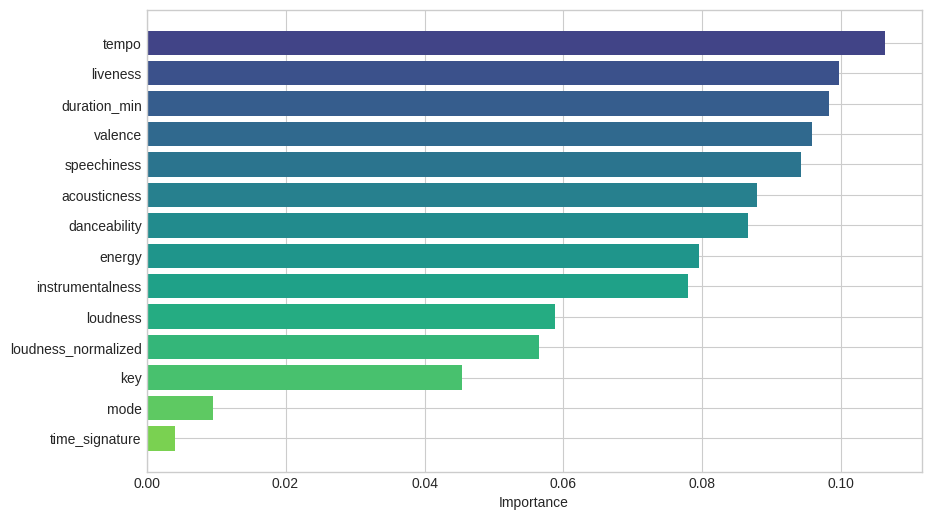

In [104]:
fi = pd.DataFrame({'Feature': feature_columns, 'Importance': best_model.feature_importances_})
fi = fi.sort_values('Importance', ascending=False)
fi.to_csv('Model/feature_importance.csv', index=False)

plt.figure(figsize=(10, 6))
plt.barh(fi['Feature'], fi['Importance'], color=plt.cm.viridis(np.linspace(0.2, 0.8, len(fi))))
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.savefig('visualizations/feature_importance.png', dpi=150)
plt.show()

# Part 3: Operation Predict

## 3.1 Prediction

In [54]:
model = joblib.load('Model/best_model.pkl')
with open('Model/model_info.json') as f:
    info = json.load(f)

print(f"{info['model_name']} loaded")
print(f"Accuracy: {info['test_accuracy']:.4f}")
print(f"F1 Score: {info['test_f1_score']:.4f}")

Decision Tree (Tuned) loaded
Accuracy: 0.8931
F1 Score: 0.1095


Get sample input from X_test.

In [72]:
idx = np.random.choice(len(X_test), 200, replace=False)
sample = df.loc[X_test.index[idx]].copy()
sample.to_csv('sample_input.csv', index=False)
sample_X = sample[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)

Begin prediction.

In [81]:
preds = model.predict(sample_X)
probs = model.predict_proba(sample_X)[:, 1]

sample['prediction'] = preds
sample['probability'] = probs
sample['result'] = sample['prediction']

cols = ['track_name', 'artists', 'popularity', 'is_hit', 'result', 'probability']
cols = [c for c in cols if c in sample.columns]
print(sample[cols].to_string(index=False))

                                                                     track_name                                                                                                                                                                                                                                                                                                                            artists  popularity  is_hit  result  probability
                                                                          十分. 愛                                                                                                                                                                                                                                                                                                                        Stephy Tang          20       0       0     0.000000
                                                                   Vazhiyarikil                                 

In [106]:
false_positive = 0
false_negative = 0
for i, row in sample.iterrows():
    if row['result'] == 0 and row['is_hit'] != 0:
        false_negative += 1
    if row['result'] == 1 and row['is_hit'] != 1:
        false_positive += 1
print(f"Predicted hit but not hit: {false_positive}")
print(f"Predicted not hit but hit: {false_negative}")

correct = len(preds) - (false_positive + false_negative)
print(f"Accuracy: {correct}/{len(preds)} ({correct/len(preds)*100:.1f}%)")

Predicted hit but not hit: 6
Predicted not hit but hit: 8
Accuracy: 186/200 (93.0%)


## 3.2 Streamlit application (Bonus)

Install streamlit on a local machine.

In [ ]:
# pip install streamlit

Place the app.py in the same directory as the Model folder (got from the previous steps):

- project_root
  - app.py
  - Model
    - best_model.pkl
    - feature_column.json
    - feature_importance.csv
    - model_info.json


Then run the application via command:

In [ ]:
# streamlit run app.py

In [ ]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json

st.title("Music Hit Prediction")
st.set_page_config(page_title="Music Hit Prediction")

def load_model():
    model = joblib.load('Model/best_model.pkl')
    with open('Model/feature_columns.json', 'r') as f:
        feature_columns = json.load(f)
    with open('Model/model_info.json', 'r') as f:
        model_info = json.load(f)
    feature_importance = pd.read_csv('Model/feature_importance.csv')
    return model, feature_columns, model_info, feature_importance

def style_result(val):
    if val == 'Hit':
        return 'color: green'
    elif val == 'Not Hit':
        return 'color: red'
    return ''


st.header("Load Model")
try:
    model, feature_columns, model_info, feature_importance = load_model()
    st.write(f"Model loaded: {model_info['model_name']}")
    st.write(f"Accuracy: {model_info['test_accuracy']:.2%} | F1 Score: {model_info['test_f1_score']:.2%}")
except Exception as e:
    st.error(f"Error loading model: {e}")
    st.stop()


st.header("Upload CSV File")
uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)

    X = pd.DataFrame()
    for col in feature_columns:
        if col in df.columns:
            X[col] = df[col]
        else:
            X[col] = 0

    X = X.fillna(0)


    st.header("Predictions")
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]

    df['result'] = predictions
    df['probability'] = probabilities

    print(probabilities)

    # If popularity column exists, show accuracy
    if 'is_hit' in df.columns:
        false_positive = 0
        false_negative = 0
        for i, row in df.iterrows():
            if row['result'] == 0 and row['is_hit'] != 0:
                false_negative += 1
            if row['result'] == 1 and row['is_hit'] != 1:
                false_positive += 1

        correct = len(df) - (false_positive + false_negative)

        st.write(f"Predicted hit but not hit: {false_positive}")
        st.write(f"Predicted not hit but hit: {false_negative}")
        st.write(f"**Accuracy:** {correct}/{len(df)} ({correct/len(df)*100:.1f}%)")

    display_cols = ['track_name', 'artists', 'is_hit', 'result', 'probability']
    display_cols = [c for c in display_cols if c in df.columns]

    display_df = df[display_cols].copy()
    display_df['result'] = display_df['result'].map({0: 'Not Hit', 1: 'Hit'})
    display_df['is_hit'] = display_df['is_hit'].map({0: 'Not Hit', 1: 'Hit'})
    styled_df = display_df.style.applymap(style_result, subset=['result'])
    if 'is_hit' in display_cols:
        styled_df = styled_df.applymap(style_result, subset=['is_hit'])
    st.dataframe(styled_df)


st.header("Feature Importance")

fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
ax.barh(top_features['Feature'], top_features['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Important Features')
plt.tight_layout()
st.pyplot(fig)


## 3.3 Summary

### Problem

Predict whether a song could be a hit song based on audio features (popularity >= 65), in order to help with commercial behaviors.

---

### Data

89,741 tracks from Kaggle Spotify Dataset and Spotify&Last.fm APIs.

Including:
- original audio features (danceability, loudness, speechiness, ...)
- metadata features (mode, time_signature, ...)
- engineered features (duration_min, loudness_normalized)

---

### Model

| Model | Accuracy | F1 Score |
|-------|----------|----------|
| Decision Tree | 0.9328 | 0.0049 |
| Random Forest | 0.9357 | 0.0000 |
| XGBoost | 0.9353 | 0.0102 |
| **Tuned Decision Tree** | **0.8931** | **0.1095**|
| Tuned Random Forest | 0.9330 | 0.0491 |
| Tuned XGBoost | 0.9355 | 0.0119 |

Picked Tuned Decision Tree to be the best model.

---

### Results

Within 200 sample tracks
- Predicted hit but not hit: 6
- Predicted not hit but hit: 8

Accuracy: 186/200 (93.0%)

---

### Key Observations

- F1 Score is more important than Accuracy for imbalanced data.
- Top 3 most important features for prediction are tempo, liveness, duration_min

---

### Limitations

- Data is imbalanced: only 7% songs are hit songs.
- Data is kind of outdated: Spotify has restricted access to the Audio Features API for regular developer accounts recently.
- Audio features only: lyrics, languages, and cultural trends are not captured.
- F1 scores are low: the best f1 score is 0.1095, still needs improving.
- Static threshold: fixed threshold (65) may not reflect changing industry standards.

---

### Next Steps

- Fetch data from newly released songs in other ways.
- Add more features like artist follower count, languages, professional ratings.
- Try different thresholds like top 25% instead of fixed popularity.
- Combine multiple models to improve the accuracy of predictions.
- Train the model with neural networks, benefiting from deep learning.